In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##### X -> [number of hours you study, number of hours you sleep]
##### y -> [Score in a test]

In [2]:
X = np.array(([3, 5], [5, 1], [10, 2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

#### Scale the inputs

In [3]:
X = X/np.amax(X, axis=0)
y = y/100 #maximum test score is 100

#### Forward Propogation

In [4]:
class Neural_Network(object):
    def __init__(self):
        #Define hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (Parameters)
        self.W1 = np.random.randn(self.inputLayerSize, \
                              self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize, \
                              self.outputLayerSize)
    def forward(self, X):
        #Propogate inputs through network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yhat = self.sigmoid(self.z3)
        return yhat
    
    def sigmoid(self, z):
    #Apply sigmoid activation function to scalar, vector
        return 1/(1+np.exp(-z))
    
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W1 and W2
        self.yhat = self.forward(X)

        delta3 = np.multiply(-(y-self.yhat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)

        return dJdW1, dJdW2

    def sigmoidPrime(self, z):
        #Derivative of Sigmoid function
        return np.exp(-z)/((1+np.exp(-z))**2) 
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
    
    
    #Helper functions for interacting with other methods/classes
    
    def getParams(self):
        #Get W1 and W2 rolled into vector
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                            (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                            (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [14]:
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        #test one gradient at a time
        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            #adding epsilon and compute cost function
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            #subtracting epsilon and compute cost function
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad

In [15]:
numgrad = computeNumericalGradient(NN, X, y)
grad = NN.computeGradients(X, y)

In [16]:
numgrad

array([ 0.0145585 , -0.00332531,  0.03755512,  0.01084566, -0.00292524,
        0.05017884, -0.15716647, -0.12195872, -0.20127383])

In [17]:
grad

array([ 0.0145585 , -0.00332531,  0.03755512,  0.01084566, -0.00292524,
        0.05017884, -0.15716647, -0.12195872, -0.20127383])

In [26]:
np.linalg.norm(grad-numgrad)/np.linalg.norm(grad+numgrad) #to quantify how similar they are

8.85014317739073e-11

## Training

In [27]:
from scipy import optimize

In [28]:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res


In [29]:
T = trainer(NN)

In [30]:
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 84
         Function evaluations: 105
         Gradient evaluations: 105


Text(0, 0.5, 'Cost')

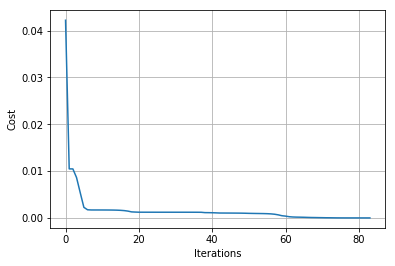

In [32]:
plt.plot(T.J)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [33]:
NN.costFunctionPrime(X,y)

(array([[ 1.02569140e-06, -1.24174381e-06, -1.97697245e-07],
        [ 2.25577316e-06, -7.24645546e-07, -1.84330228e-06]]),
 array([[ 2.57170985e-07],
        [ 6.01276611e-09],
        [-2.98381900e-06]]))

In [34]:
NN.forward(X)

array([[0.74998134],
       [0.82003108],
       [0.9299273 ]])

In [35]:
y

array([[0.75],
       [0.82],
       [0.93]])

In [38]:
#Test network for various combinations of sleep/study:
hoursSleep = np.linspace(0, 10, 100)
hoursStudy = np.linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = np.meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()


In [39]:
allOutputs = NN.forward(allInputs)

Text(0, 0.5, 'Hours Study')

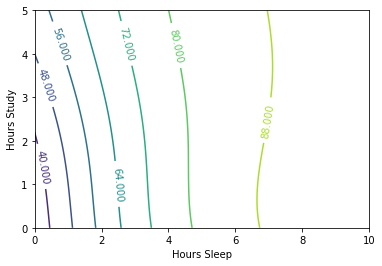

In [41]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = plt.contour(xx,yy,100*allOutputs.reshape(100, 100))
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('Hours Sleep')
plt.ylabel('Hours Study')

Text(0.5, 0, 'Test Score')

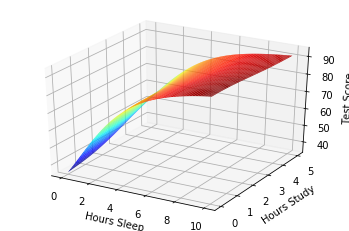

In [44]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=plt.cm.jet)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')